# QBUS6850: Tutorial 09 – Extreme Gradient Boosting

**Objective**:
1. Get familiar with Gradient Boosting algorithm for regression and classification
2. Learn how to use `XGBoost` package to do the classification and regression



**Review: Lecture 8**


**Review: tutorial 8**
1. Random Forest Classifier  
    `from sklearn import ensemble`  
    `ensemble.RandomForestClassifier(n_estimator, max_depth)`  
    
    `param_grid = {'n_estimators': np.arange(), 'max_depth': np.arange()}`  
    `clf_cv = GridSearchCV(ensemble.RandomForestClassifier(class_weight = 'balanced'), param_grid)`  
    `clf_cv.fit(X_train, y_train)`  
    `clf_cv.best_estimator_`  
    `clf_cv.best_estimator_.predict(X_test)`  
  
  
2. Adaboost  
    `ensemble.AdaBoostClassifier()`


3. VotingClassifier  
    `from sklearn.ensemble import VotingClassifier`  
    `VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')`
   

4. Multi-class Classification


# Task 1: Gradient Boosting Classification 
In this task, let's review the example in Lecture 08.
We will build a Gradient Boosting Decision Tree to do the classificatoin on Iris dataset.
This dataset contains <span class="girk">150 data point</span>, and each data is described with <span class="girk">4 features</span> (namely sepal length & width(cm) and petal length & width (cm) )

Please refer to QBUS6850_Lecture08.pdf for the detailed explanation.

## Step 0: Import libs and data

Read the code below, and try to answer the following questions:
1. What is the `T` in line 22?
2. what is the purpose of `get_dummies` in line 26?


In [90]:
import numpy as np
import pandas as pd
from random import shuffle
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor

# load the dataset
iris = datasets.load_iris()
X = iris.data
t = iris.target

In [91]:
np.random.seed(5)

# randomly shuffle the dataset
N = len(t)
index = list(range(N))
shuffle(index)

In [92]:
# select the first 12 data to train the model
m = 12
T = 3 # line 22

X1 = X[index[:m]]
t1 = t[index[:m]]
t1 = pd.get_dummies(t1) # line 26

F = np.full((m,3),0.0) # == np.zeros((m,T))
rho = 1


## Step 1: Initial Models and Initial Probability (from F to P)

Classification is also a regression problem with a specially defined loss function, such as the cross entropy over the data.

Before you start reading the following code, please quickly review what is mathematical definition of cross entropy.  

Consider the case of three classes “1”, “2”, “3” for single datum $\mathbf{x}_{n}$ with three models $F_{1}\left(x_{n}\right)$, $F_{2}\left(x_{n}\right)$, $F_{3}\left(x_{n}\right)$

$$
L\left(t_{n}, F\left(\mathbf{x}_{n}\right)\right)=-\left[t_{n_{1}} \log \left(P_{1}\left(\mathbf{x}_{n}\right)\right)+t_{n 2} \log \left(P_{2}\left(\mathbf{x}_{n}\right)\right)+t_{n 3} \log \left(P_{2}\left(\mathbf{x}_{n}\right)\right)\right]
$$
where
$$
P_{j}\left(\mathbf{x}_{n}\right)=\frac{e^{F_{j}\left(x_{n}\right)}}{e^{F_{1}\left(\mathbf{x}_{n}\right)}+e^{F_{2}\left(\mathbf{x}_{n}\right)}+e^{F_{3}\left(\mathbf{x}_{n}\right)}}, \quad j=1,2,3
$$

In [94]:
# define a new function for cal the probability
def FtoP(F):
    expF = np.exp(F)
    a = expF.sum(axis = 1) # summation of each row
    P = expF / a[:,None] # a[:,None] change the shape from (12,) to (12,1)
    return P

## Step 2: Calculate the negative gradient


$$
-g_{j}\left(\mathbf{x}_{n}\right)=-\frac{\partial L\left(t_{n}, F\left(\mathbf{x}_{n}\right)\right)}{\partial F_{j}\left(\mathbf{x}_{n}\right)}=t_{n j}-\frac{e^{F_{j}\left(\mathbf{x}_{n}\right)}}{e^{F_{1}\left(\mathbf{x}_{n}\right)}+e^{F_{2}\left(\mathbf{x}_{n}\right)}+e^{F_{3}\left(\mathbf{x}_{n}\right)}}=t_{n j}-P_{j}\left(\mathbf{x}_{n}\right)
$$

In [96]:
P = FtoP(F) # F: initial F0(X) -> P: initial P0
NegG = t1.values - P # negative gradient = t - p

print(NegG)

[[-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]
 [ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]
 [ 0.66666667 -0.33333333 -0.33333333]]


## Step 3: Modeling from X to g(1) g(2) and g(3)

Build a decision tree $h_1(x)$ of depth 1 from $X$ to $-g_1$, $-g_2$, and $-g_3$.

For simplicity, we define max_depth =2 for each tree.

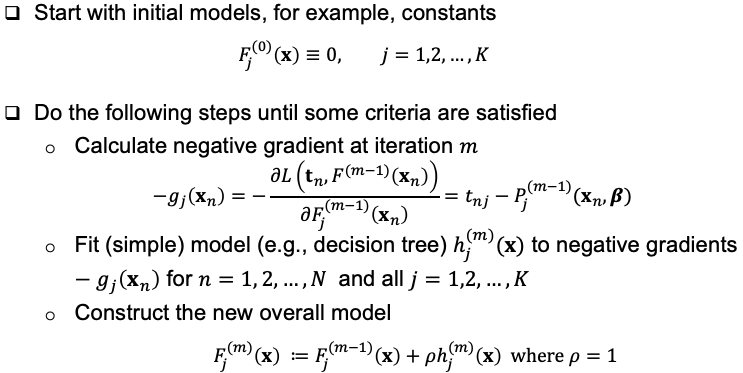

In [97]:
baseH0 = []
baseH1 = []
baseH2 = []

# First Round
# for each t, build up a regressor: fit model to negative gradients
# model 1
regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
h0 = regressor.fit(X1, NegG[:,0])
baseH0.append(h0)

# model 2
regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
h1 = regressor.fit(X1, NegG[:,1])
baseH1.append(h1)

# model 3
regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
h2 = regressor.fit(X1, NegG[:,2])
baseH2.append(h2)

In [103]:
baseH0

[DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')]

## Step 4: Updating $F:=F+\rho h $ 

$\rho = 1$ for simplicity 

In [98]:
h0.predict(X1)

array([-0.33333333, -0.33333333,  0.66666667, -0.33333333, -0.33333333,
        0.66666667, -0.33333333,  0.66666667, -0.33333333,  0.66666667,
       -0.33333333,  0.66666667])

In [99]:
# construct the new overall model
F[:,0] = F[:,0] + rho*h0.predict(X1) # X1 = X[index[:12]]
F[:,1] = F[:,1] + rho*h1.predict(X1)
F[:,2] = F[:,2] + rho*h2.predict(X1)

## Step 5 & 6: F to P and Negative Gradient again

In [100]:
# prepare the negative gradient for the next iteration
P = FtoP(F)
NegG = t1.values - P

## Step 7: Modelling Negative Gradients again

we have the second set of basic modeller h1(x), h2(x), and h3(x): Decision trees of depth 1

Note: the splitting points for this set of basic models are the same as the first set of basic models.

In [101]:
# Predict for a new case
x = X[index[148:150]]
F0 = 0.0
F1 = 0.0
F2 = 0.0

# the models are stored in BaseH0, BaseH1 and BaseH2
F0 = F0 + baseH0[0].predict(x) 
F1 = F1 + baseH1[0].predict(x)
F2 = F2 + baseH2[0].predict(x) 

## Step 8: Final models 



In [102]:
F = np.vstack((F0,F1,F2))
F = F.T

# We will select the largest probability as the class label index.
predictedP = FtoP(F)
print(predictedP)

[[0.57611688 0.21194156 0.21194156]
 [0.33333333 0.33333333 0.33333333]]


# Task 2: Installing the XGBoost package

Open the Command Termial,

If you are __python3__ user, then type in __"pip3 install xgboost"__ to install the XGBoost.

If you are __python2__ user, then type in __"pip install xgboost"__ to install the XGBoost.



For more information, please refer the official document at: https://xgboost.readthedocs.io/en/latest/build.html#

# Task 3: Predict Onset of Diabetes (Classification)

This tutorial is based on https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

In this task, we are going to use the Pima Indians onset of diabetes dataset.

This dataset is comprised of 8 input variables that describe medical details of patients and one output variable to indicate whether the patient will have an onset of diabetes within 5 years.

You can learn more about this dataset on the UCI Machine Learning Repository website.

This is a good dataset for a first XGBoost model because all of the input variables are numeric and the problem is a simple binary classification problem. It is not necessarily a good problem for the XGBoost algorithm because it is a relatively small dataset and an easy problem to model.

Download this dataset and place it into your current working directory with the file name “[pima-indians-diabetes.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv)”.

## Step1: Load and Prepare Data

In this section we will load the data from file and prepare it for use for training and evaluating an XGBoost model.

We will start off by importing the classes and functions we intend to use in this tutorial.

In [18]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Next, we can load the CSV file as a NumPy array using the NumPy function loadtext().

In [19]:
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")

We must separate the columns (attributes or features) of the dataset into input patterns (X) and output patterns (Y). We can do this easily by specifying the column indices in the NumPy array format.

In [20]:
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

Finally, we must split the X and Y data into a training and test dataset. The training set will be used to prepare the XGBoost model and the test set will be used to make new predictions, from which we can evaluate the performance of the model.

For this we will use the train_test_split() function from the scikit-learn library. We also specify a seed for the random number generator so that we always get the same split of data each time this example is executed.



In [21]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=test_size, 
                                                    random_state=seed)

## Step 2: Train the XGBoost Model

XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework.

This means we can use the full scikit-learn library with XGBoost models.

The XGBoost model for classification is called XGBClassifier. We can create and and fit it to our training dataset. Models are fit using the scikit-learn API and the model.fit() function.

Parameters for training the model can be passed to the model in the constructor. Here, we use the sensible defaults.

In [22]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

You can see the parameters used in a trained model by printing the model, for example:

In [23]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


You can learn more about the defaults for the XGBClassifier and XGBRegressor classes in the [XGBoost Python scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

You can learn more about the meaning of each parameter and how to configure them on the [XGBoost parameters page](https://xgboost.readthedocs.io/en/latest//parameter.html).

We are now ready to use the trained model to make predictions.

## Step 3: Make Predictions with XGBoost Model

We can make predictions using the fit model on the test dataset.

To make predictions we use the scikit-learn function model.predict().

By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1.

In [24]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

Now that we have used the fit model to make predictions on new data, we can evaluate the performance of the predictions by comparing them to the expected values. For this we will use the built in accuracy_score() function in scikit-learn.

In [25]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.95%


# Task 4: Boston Housing (regression)

In this task, we are going to use the Boston housing dataset.

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive (http://lib.stat.cmu.edu/datasets/boston), and has been used extensively throughout the literature to benchmark algorithms. However, these comparisons were primarily done outside of Delve and are thus somewhat suspect. The dataset is small in size with only 506 cases.

For more information of this dataset, please refer: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html


## Step1: Load and Prepare Data

Similar to the previous task, we will load the data and prepare it for use for training and evaluating an XGBoost model.


In [26]:
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_boston

rng = np.random.RandomState(31337)

We could use __load_boston()__ function to load the dataset.

In [27]:
print("Boston Housing: regression")
boston = load_boston()

Boston Housing: regression


Define the X and Y for your XGBoost model.

In [28]:
y = boston['target']
X = boston['data']

You could also print out the dataset information by calling the __shape__ function.

In [29]:
print(X.shape)

(506, 13)


Now you can see our dataset contains 506 datapoint, and each datapoint is described with 13 features.


## Step 2: Applying k-fold Cross Validation

Cross-validation is a statistical method used to estimate the skill of machine learning models.

It is commonly used in applied machine learning to compare and select a model for a given predictive modeling problem in order to flag problems like overfitting and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem)

In this section, we will use k-fold cross-validation.
In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. 
Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. 
The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. 
The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once. 
10-fold cross-validation is commonly used, but in general k remains an unfixed parameter.


In [30]:
kf = KFold(n_splits=2, shuffle=True, random_state=rng)


For more information on KFold Cross Validation, please refer to: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation

You may also refer to the following link for the detailed information of each parameter and how to configure them by using scikit libs:
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

## Step 3: Train and Make Prediction with XGBRegressor()

We then call __split()__ function to generate indices to split data into training and test set.
For each training and test set, we define a new __XGBRegressor()__ model.

In [31]:
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

[08:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
22.226372273594922
[08:34:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
9.906392481416354


## Step 4: Parameter Optimization

Now we are able to use __XGBRegressor()__ function to make prediction.

One remaining issue is about the value selection of the hyperparameters, i.e. learning rate alpha, number of classifiers (__n_estimators__), and maximun depth of each tree model (__max_depth__).

By default, this function defines __learning_rate=0.1__, __n_estimators=100__, and __max_depth=3__.
However, this settings may not suitable for our case.
In order to find out what hyperparameter settings are suitable for our case, we use __GridSearchCV__ function to test different value of these hyperparameters.
Note that, in this experiment, we only test different __max_depth__ and __n_estimators__.

In [36]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
clf.fit(X,y)

print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6001029721598573
{'max_depth': 4, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.4s finished
